In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
import numpy as np
from keras.models import Model
from keras.layers import Activation, Dense, LSTM, Input
from keras.optimizers import Adam, RMSprop
import tensorflow as tf
import matplotlib.pyplot as plt
from os import path

Load Dataset

In [13]:
def load_dataset() -> tuple([pd.DataFrame, pd.DataFrame, pd.DataFrame]):
    train = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\train.csv")
    greeks = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\greeks.csv")
    test = pd.read_csv("C:\\Projects\\kaggle\\competitions\\identify-age-related-conditions\\data\\test.csv")
    train.head()
    return (train, greeks, test)

Preprocess the training data

In [14]:
def preprocess_data(df: pd.DataFrame) -> tuple([np.ndarray, np.ndarray]):
    y = df["Class"]
    x = df.loc[:, df.columns != "Class"]
    
    #fill NaN values with zeroes
    x = x.fillna(0) 
    
    #EJ needs to be categorical
    x.EJ.replace(['A', 'B'], [0, 1], inplace=True)
    x.EJ
    
    #scale the inputs around 0
    scaler = StandardScaler()
    norm_columns = []
    for i in range(1, 57):
        if(i == x.columns.get_loc("EJ")):continue
        norm_columns.append(i)
    x.iloc[:, norm_columns] = scaler.fit_transform(x.iloc[:, norm_columns].to_numpy())
    
    #convert the dataframes to numpy-arrays
    x = x.iloc[:, 1:-1].to_numpy()
    y = y.to_numpy()
    print(f"x shape: {x.shape} \ny shape: {y.shape}")
    
    return (x,y)

In [15]:
def preprocess_test_data(x: pd.DataFrame) -> tuple([np.ndarray, np.ndarray]):
    #fill NaN values with zeroes
    x = x.fillna(0) 
    
    #EJ needs to be categorical
    x.EJ.replace(['A', 'B'], [0, 1], inplace=True)
    x.EJ
    
    #scale the inputs around 0
    scaler = StandardScaler()
    norm_columns = []
    for i in range(1, 57):
        if(i == x.columns.get_loc("EJ")):continue
        norm_columns.append(i)
    x.iloc[:, norm_columns] = scaler.fit_transform(x.iloc[:, norm_columns].to_numpy())
    id = x.iloc[:, 0]
    
    #convert the dataframes to numpy-arrays
    x = x.iloc[:, 1:-1].to_numpy()
    return x, id

Build the AI-model

In [16]:
def build_model(input_shape:int, output_shape:int, units1: int, units2: int, units3: int, activation1: str, 
                activation2: str, activation3: str, optimizer: tf.keras.optimizers.Optimizer, learning_rate: float) -> Model:
    input = Input(shape=input_shape)
    x = Dense(units=units1, activation=activation1)(input)
    x = Dense(units=units2, activation=activation2)(x)
    x = Dense(units=units3, activation=activation3)(x)
    output = Dense(units=output_shape, activation="sigmoid")(x)
    model = Model(inputs=[input], outputs=[output])
    
    model.compile(loss="binary_crossentropy",
              optimizer=optimizer(learning_rate=learning_rate),
              metrics=["accuracy"])
    
    return model

Fit the model

In [17]:
es_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=1,
        restore_best_weights=True,
        min_delta=0.005
    )
 
def fit_model(model: Model, x: np.ndarray, y: np.ndarray, epochs: int, split: float) -> Model:
    #split train and validation
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=split, random_state=42)
    #fit the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val,y_val), callbacks=[es_callback])
    return history 

Plot accuracy and loss function of model

In [18]:
def plot_acc(history:Model):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Run Methods

In [19]:
grid_params = {"units1": [8,16], "units2": [16,32], "units3": [32,64], "activation1": ["relu"], "activation2": ["relu"], 
          "activation3": ["relu"], "optimizer": [Adam, RMSprop], "learning_rate": [0.001, 0.0005]}

(train, greeks, test) = load_dataset()
(x_train, y_train) = preprocess_data(train)
x_test, id_number = preprocess_test_data(test)
input_shape = len(x_train[1])
output_shape = 1

#GridSearch
grid = ParameterGrid(param_grid = grid_params)
results = []
for idx,params in enumerate(grid):
        model = build_model(input_shape=input_shape, output_shape=output_shape, **params)
        history = fit_model(model, x_train, y_train, 100, 0.2)
        val_loss = history.history['val_loss'][-1]    
        val_acc = history.history['val_accuracy'][-1]
        results.append([val_loss, val_acc])

x shape: (617, 55) 
y shape: (617,)
Epoch 1/100
16/16 [==============================] - 1s 11ms/step - loss: 0.6501 - accuracy: 0.7951 - val_loss: 0.6142 - val_accuracy: 0.8145
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.8276 - val_loss: 0.5696 - val_accuracy: 0.8145
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5413 - accuracy: 0.8276 - val_loss: 0.5313 - val_accuracy: 0.8145
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.8276 - val_loss: 0.4982 - val_accuracy: 0.8145
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.8276 - val_loss: 0.4733 - val_accuracy: 0.8145
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4326 - accuracy: 0.8276 - val_loss: 0.4559 - val_accuracy: 0.8145
Epoch 6: early stopping
Epoch 1/100
16/16 [==============================] - 1s 10ms/step - loss: 0.7135 - accuracy: 

get best params

In [20]:
val_accuracies = [i[1] for i in results]
val_losses= [i[0] for i in results]
best_acc = val_accuracies.index(max(val_accuracies))
best_loss = val_losses.index(min(val_losses))
print(f"best acc at index {best_acc}: {max(val_accuracies)}")
print(f"best loss at index {best_loss}: {min(val_losses)}")
print(grid[best_acc])

best acc at index 6: 0.8951612710952759
best loss at index 15: 0.25923117995262146
{'units3': 32, 'units2': 32, 'units1': 16, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.001, 'activation3': 'relu', 'activation2': 'relu', 'activation1': 'relu'}


save best model

Epoch 1/100
16/16 [==============================] - 1s 10ms/step - loss: 0.6768 - accuracy: 0.6815 - val_loss: 0.6359 - val_accuracy: 0.8145
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5701 - accuracy: 0.8276 - val_loss: 0.5900 - val_accuracy: 0.8145
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4954 - accuracy: 0.8276 - val_loss: 0.5519 - val_accuracy: 0.8145
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.8296 - val_loss: 0.5085 - val_accuracy: 0.8145
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.8499 - val_loss: 0.4755 - val_accuracy: 0.8387
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3233 - accuracy: 0.8702 - val_loss: 0.4516 - val_accuracy: 0.8468
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2864 - accuracy: 0.8925 - val_loss: 0.4315 - val_accuracy: 0.8548
Epoch 8/100


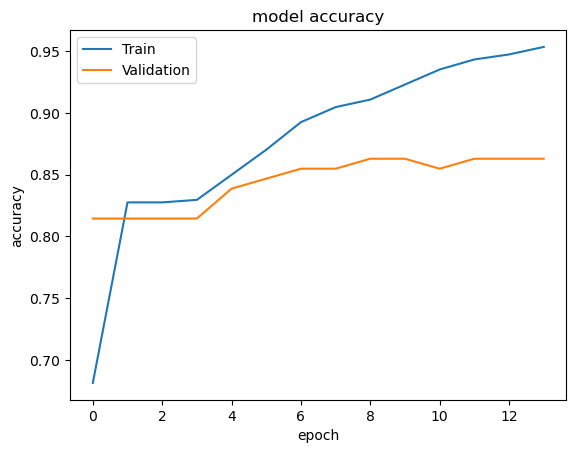

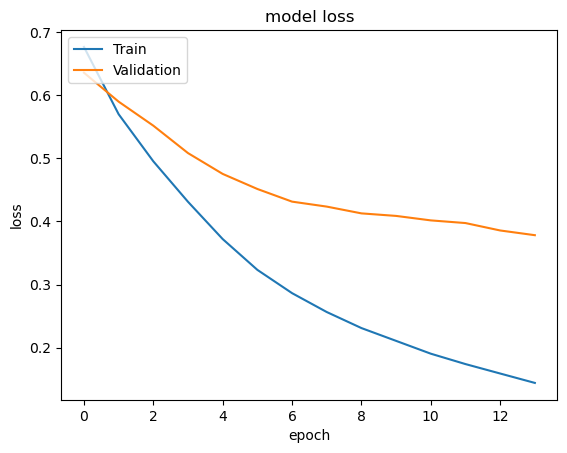

In [26]:
model = build_model(input_shape=input_shape, output_shape=output_shape, **grid[best_acc])
history = fit_model(model, x_train, y_train, 100, 0.2)
plot_acc(history)

Submission

In [ ]:
submission = pd.DataFrame()
prediction = model.predict(x_test)
submission.insert(0, "Id", id_number, False)
submission.insert(1, "class_0", [round(1-i[0],2) for i in prediction], True)
submission.insert(2, "class_1", [round(i[0],2) for i in prediction], True)
submission.to_csv("/kaggle/working/submission.csv",index = False)